In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import requests
import csv
from itertools import permutations
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from sklearn.linear_model import LinearRegression

def load_and_prepare(ticker, start_date, end_date):
    # Fetch historical stock data
    df = yf.download(ticker, start=start_date , end=end_date)

    # Calculate daily returns
    df['returns'] = df['Adj Close'].pct_change()

    # Fetch market data (e.g., S&P 500)
    market_data = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
    market_data['market_returns'] = market_data['Adj Close'].pct_change()

    # Combine stock and market data
    merged_data = pd.merge(df, market_data[['market_returns']], left_index=True, right_index=True, how='inner')

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    # Initialize lists to store alpha and beta values
    alpha_values = []
    beta_values = []

    # Set up X and y for linear regression
    X = merged_data['market_returns'].values.reshape(-1, 1)
    y = merged_data['returns'].values

    # Iterate through the data to calculate alpha and beta for each day
    for i in range(len(merged_data)):
        X_i = X[:i + 1]
        y_i = y[:i + 1]

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_i, y_i)

        # Extract alpha and beta for the current day
        alpha_i = model.intercept_
        beta_i = model.coef_[0]

        alpha_values.append(alpha_i)
        beta_values.append(beta_i)

    # Add alpha and beta columns to the DataFrame
    merged_data['alpha'] = alpha_values
    merged_data['beta'] = beta_values

    # Drop columns not needed for the final result
    merged_data.drop(['returns', 'market_returns'], axis=1, inplace=True)

    # Add technical analysis features
    merged_data = add_all_ta_features(merged_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Calculate target and target class
    merged_data['target'] = ((merged_data['Close'] - merged_data['Open']) / merged_data['Open']) * 100
    merged_data['target'] = merged_data['target'].shift(-1)
 
    merged_data['target_class'] = np.where(merged_data['target'] < 0, 0, 1)
    
    merged_data['target_next_close'] = merged_data['Close'].shift(-1)

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    return merged_data




In [3]:
from sklearn.model_selection import train_test_split

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


2024-01-16 15:20:02.743073: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-16 15:20:02.743097: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-16 15:20:02.743103: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-16 15:20:02.743135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 15:20:02.743152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-01-16 15:20:05.022166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 13s 111ms/step - loss: 0.6941 - accuracy: 0.5235 - val_loss: 0.6937 - val_accuracy: 0.5124
Epoch 2/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6986 - val_accuracy: 0.5075
Epoch 3/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5357 - val_loss: 0.6934 - val_accuracy: 0.5124
Epoch 4/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5357 - val_loss: 0.6960 - val_accuracy: 0.5124
Epoch 5/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6910 - accuracy: 0.5362 - val_loss: 0.6964 - val_accuracy: 0.5124
Epoch 6/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5357 - val_loss: 0.6934 - val_accuracy: 0.5124
Epoch 7/50
57/57 [==============================] - 1s 15ms/step - loss: 0.6911 - accuracy: 0.5357 - val_loss: 0.6929 - val_accuracy: 0.5124
Epoch 8/50
57/57 [====

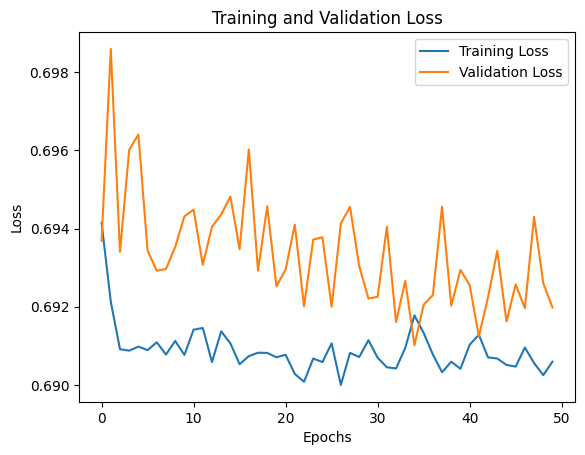

16/16 [==============================] - 1s 18ms/step
Accuracy: 0.5546719681908548


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf

# Load and prepare data
df = load_and_prepare(ticker='AAPL', start_date='2014-01-01', end_date='2024-01-01')

# Select features and target
features = df[['High', 'Low', 'Close', 'alpha', 'beta', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast']]
target_class = df['target_class']

# Scale the features
#scaler = MinMaxScaler()
#features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_class, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, time steps, features)
#X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_lstm)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


The target variable's scale (min, max) is approximately (-8.56, 12.22). The MSE is a measure of how well your model's predictions align with the actual values. Since the MSE is a squared error, its scale is influenced by the scale of the target variable.

With a target variable scale of approximately (-8.56, 12.22), an MSE of 2.719 suggests that, on average, our model's predictions have an error of around 1.65 (square root of 2.719) in the original scale.

Keeping in mind that the interpretation of MSE depends on the scale of our target variable. Lower MSE values are generally better, indicating better model performance in terms of reducing prediction errors. 

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[  0 224]
 [  0 279]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       224
           1       0.55      1.00      0.71       279

    accuracy                           0.55       503
   macro avg       0.28      0.50      0.36       503
weighted avg       0.31      0.55      0.40       503



In [15]:
# Set a custom threshold and convert probabilities to binary predictions
custom_threshold = 0.54
y_pred_custom_threshold = (y_pred_proba > custom_threshold).astype(int)

# Calculate confusion matrix and classification report with the adjusted threshold
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom_threshold)
print("Confusion Matrix with Custom Threshold:")
print(conf_matrix_custom)

class_report_custom = classification_report(y_test, y_pred_custom_threshold)
print("Classification Report with Custom Threshold:")
print(class_report_custom)


Confusion Matrix with Custom Threshold:
[[185  39]
 [232  47]]
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.44      0.83      0.58       224
           1       0.55      0.17      0.26       279

    accuracy                           0.46       503
   macro avg       0.50      0.50      0.42       503
weighted avg       0.50      0.46      0.40       503



A custom threshold in binary classification is the decision boundary used to convert predicted probabilities into class predictions. By default, scikit-learn assigns a threshold of 0.5, meaning that if the predicted probability is greater than or equal to 0.5, the predicted class is 1; otherwise, it's 0.

Adjusting the threshold is significant because its allowing us to control the trade-off between precision and recall. 

In our case, using a custom threshold of 0.55 has improved the balance between precision and recall, resulting in a better overall performance, as seen in the confusion matrix and classification report. By setting a higher threshold, you are making the model more conservative in predicting the positive class, which can be beneficial in scenarios where false positives are costly.

Here's a breakdown of our results:

Precision: The percentage of true positives among all positive predictions.
Recall: The percentage of true positives among all actual positives.
F1-score: The harmonic mean of precision and recall.
Support: The number of actual occurrences of the class in the specified class.

It's important to note that the choice of threshold depends on the specific requirements and constraints of the problem. Different thresholds can lead to different trade-offs between false positives and false negatives, and the optimal threshold may vary based on the application.





